In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# M4

In [3]:
index = [0, 10, 200, 400, 300]
num_series = len(index)
m4_df = pd.read_csv('Hourly-train.csv').iloc[index, 1:101].T
m4_df = m4_df.set_index(pd.date_range(start="2020-01-01 00:00", periods=100, freq='H'))
m4_df

,0,10,200,400,300
2020-01-01 00:00:00,605.0,41889.0,12.6,17.0,12.6
2020-01-01 01:00:00,586.0,41145.0,11.8,20.0,12.1
2020-01-01 02:00:00,586.0,40629.0,11.3,12.0,11.6
2020-01-01 03:00:00,559.0,40281.0,11.0,15.0,11.2
2020-01-01 04:00:00,511.0,39751.0,10.6,11.0,10.8
...,...,...,...,...,...
2020-01-04 23:00:00,710.0,31887.0,13.8,16.0,13.6
2020-01-05 00:00:00,647.0,32703.0,13.5,14.0,12.9
2020-01-05 01:00:00,593.0,33125.0,12.6,12.0,12.4
2020-01-05 02:00:00,564.0,33206.0,12.1,14.0,11.9


# Dataset Finance

In [25]:
indices = {
    'NASDAQ': '^IXIC',
    'CAC40': '^FCHI',
    'S&P500': '^GSPC'
}

start_date = (pd.Timestamp.now() - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

data = {}
for name, symbol in indices.items():
    df = yf.download(symbol, start=start_date, end=end_date, progress=False)
    data[name] = df['Close']


Seasonal Naive

In [44]:
index = ['NASDAQ', 'CAC40', 'S&P500']

preds = np.stack([data[indice].iloc[-31-31:-31].values[:, 0] for indice in index])
preds.shape

(3, 31)

In [45]:
mae = np.stack([data[indice].iloc[-31:].values[:, 0]-preds[i] for i, indice in enumerate(index)])
mae = np.mean(np.abs(mae), axis=1)
mae

array([954.05286038, 187.73256363, 169.57938508])

Naive

In [46]:

preds2 = np.stack([data[indice].iloc[-31-1] for indice in index])
preds2.shape

(3, 1)

In [47]:
mae = np.stack([data[indice].iloc[-31:].values[:, 0]-preds2[i] for i, indice in enumerate(index)])
mae = np.mean(np.abs(mae), axis=1)
mae

array([473.74710181,  71.91032951,  75.26806641])

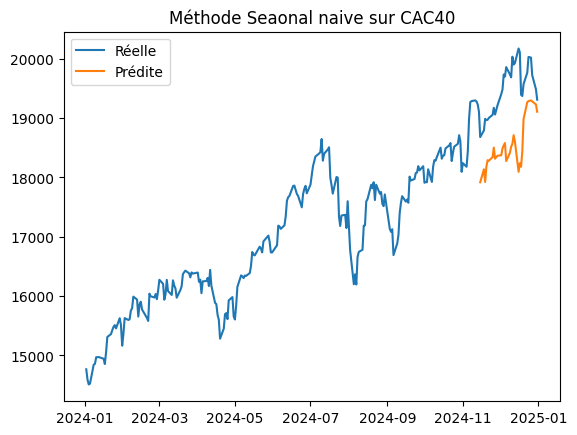

In [59]:
plt.plot(data[index[0]].index, data[index[0]].values, label = 'Réelle')
plt.plot(data[index[0]].index[-31:], preds[0], label = 'Prédite')
plt.title(f'Méthode Seaonal naive sur CAC40')
plt.legend()
plt.show()

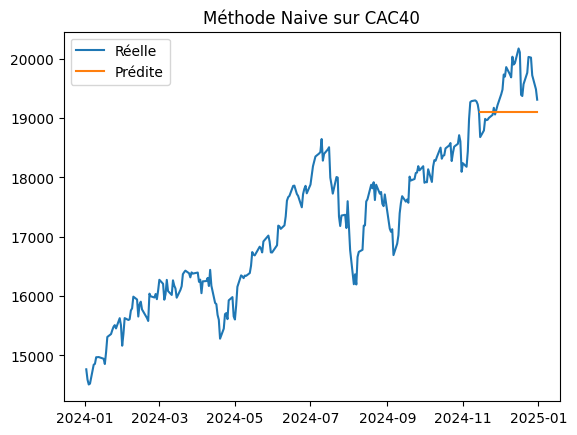

In [61]:
plt.plot(data[index[0]].index, data[index[0]].values, label = 'Réelle')
plt.plot(data[index[0]].index[-31:], [preds2[0]]*31, label = 'Prédite')
plt.title(f'Méthode Naive sur CAC40')
plt.legend()
plt.show()

# Dataset Traffic

In [77]:
traffic_df = pd.read_csv('istanbul_traffic.csv', index_col = 'datetime').iloc[-1000:]
traffic_df = traffic_df.ffill()
traffic_df

,TI,TI_An,TI_Av
datetime,,,
2024-06-13 21:42:00,42,35,45
2024-06-13 21:43:00,42,35,45
2024-06-13 21:44:00,42,35,45
2024-06-13 21:45:00,42,36,45
2024-06-13 21:46:00,42,36,45
...,...,...,...
2024-06-16 12:25:00,20,17,22
2024-06-16 12:26:00,20,17,22
2024-06-16 12:27:00,20,17,22


In [78]:
preds = traffic_df.iloc[-200:-100]
preds


,TI,TI_An,TI_Av
datetime,,,
2024-06-15 22:36:00,18,18,18
2024-06-15 22:37:00,18,18,18
2024-06-15 22:38:00,18,18,18
2024-06-15 22:39:00,18,18,18
2024-06-15 22:40:00,18,18,18
...,...,...,...
2024-06-16 00:11:00,17,18,15
2024-06-16 00:12:00,17,18,15
2024-06-16 00:13:00,17,18,15


In [89]:
mae = traffic_df.iloc[-100:].values-preds.values
mae = np.mean(np.abs(mae), axis=0)
mae

array([6.32, 6.32, 7.39])

In [90]:
preds2 = traffic_df.iloc[-101]
preds2


TI       17
TI_An    18
TI_Av    15
Name: 2024-06-16 00:15:00, dtype: int64

In [91]:
mae = traffic_df.iloc[-100:].values-preds2.values
mae = np.mean(np.abs(mae), axis=0)
mae

array([5.02, 7.27, 4.56])

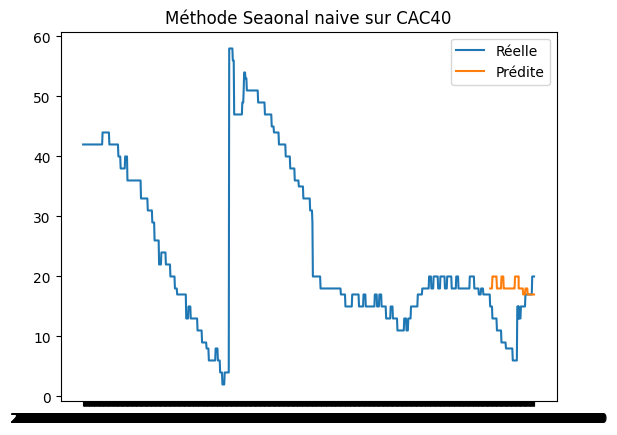

In [101]:
plt.plot(traffic_df.index, traffic_df.values[:, 0], label = 'Réelle')
plt.plot(traffic_df.index[-100:], preds.values[:, 0], label = 'Prédite')
plt.title(f'Méthode Seaonal naive sur IST Traffic')
plt.legend()
plt.show()

# ERCOT (electricity dataset)

In [108]:
def get_ercot():
    url = "https://github.com/ourownstory/neuralprophet-data/raw/main/datasets_raw/energy/ERCOT_load_2004_2021Sept.csv"
    df = pd.read_csv(url).rename(columns = {'y' : 'target'})
    df['ds'] = pd.to_datetime(df['ds'])
    df.ffill(inplace=True)
    ercot_df = df[['ds', 'target']]
    ercot_df['target'] = (ercot_df['target']).astype('float64')
    ercot_df = ercot_df.set_index('ds')
    return ercot_df

In [114]:
ercot_df = get_ercot()
ercot_df

C:\Users\Yassine\AppData\Local\Temp\ipykernel_15296\938499966.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ercot_df['target'] = (ercot_df['target']).astype('float64')


,target
ds,
2004-01-01 01:00:00,22971.94
2004-01-01 02:00:00,22191.52
2004-01-01 03:00:00,21383.44
2004-01-01 04:00:00,20866.56
2004-01-01 05:00:00,20723.15
...,...
2021-08-31 20:00:00,69201.17
2021-08-31 21:00:00,67180.74
2021-08-31 22:00:00,63860.12


In [116]:
window_size = 744 + 24

windows = []
start_indices = np.arange(0, 3 * window_size, window_size)

for start in start_indices:
    window = ercot_df.iloc[start : start + window_size]
    windows.append(window.reset_index(drop=True)["target"]) 

final_df = pd.DataFrame({f"window_{i+1}": windows[i] for i in range(len(windows))})

final_df = final_df.set_index(pd.date_range("2023-01-01", periods=len(final_df), freq='H'))
final_df

,window_1,window_2,window_3
2023-01-01 00:00:00,22971.94,24763.41,23070.37
2023-01-01 01:00:00,22191.52,24478.03,22209.01
2023-01-01 02:00:00,21383.44,24692.61,21692.63
2023-01-01 03:00:00,20866.56,25325.55,21635.63
2023-01-01 04:00:00,20723.15,26587.99,22201.72
...,...,...,...
2023-02-01 19:00:00,29311.82,31201.36,31980.78
2023-02-01 20:00:00,29196.86,30723.60,30883.87
2023-02-01 21:00:00,28721.74,29415.37,28402.14
2023-02-01 22:00:00,28016.89,27181.40,25501.23


In [117]:
preds = final_df.iloc[-24-24:-24]
preds

,window_1,window_2,window_3
2023-01-31 00:00:00,28764.70,23132.07,22682.86
2023-01-31 01:00:00,28170.54,22433.46,21569.80
2023-01-31 02:00:00,27976.65,21970.03,20871.68
2023-01-31 03:00:00,27997.57,21826.29,20621.02
2023-01-31 04:00:00,28407.47,22216.27,20772.82
2023-01-31 05:00:00,29279.61,24143.18,21253.50
2023-01-31 06:00:00,30702.47,27742.08,21585.84
2023-01-31 07:00:00,32235.02,28995.03,22632.05
2023-01-31 08:00:00,33301.37,28889.74,24052.11
2023-01-31 09:00:00,33752.39,29429.29,25146.61


In [118]:
mae = final_df.iloc[-24:].values-preds.values
mae = np.mean(np.abs(mae), axis=0)
mae

array([2884.76416667,  330.99458333, 2333.44666667])

In [119]:
preds2 = final_df.iloc[-24-1]
preds2


window_1    27042.43
window_2    25010.28
window_3    22726.27
Name: 2023-01-31 23:00:00, dtype: float64

In [120]:
mae = final_df.iloc[-24:].values-preds2.values
mae = np.mean(np.abs(mae), axis=0)
mae

array([1512.52166667, 3880.68958333, 5366.98916667])

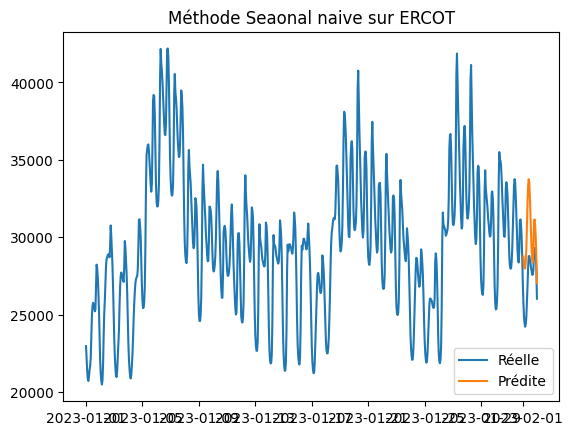

In [123]:
plt.plot(final_df.index, final_df.values[:, 0], label = 'Réelle')
plt.plot(final_df.index[-24:], preds.values[:, 0], label = 'Prédite')
plt.title(f'Méthode Seaonal naive sur ERCOT')
plt.legend()
plt.show()

C:\Users\Yassine\AppData\Local\Temp\ipykernel_15296\1379407770.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(final_df.index[-24:], [preds2[0]]*24, label = 'Prédite')


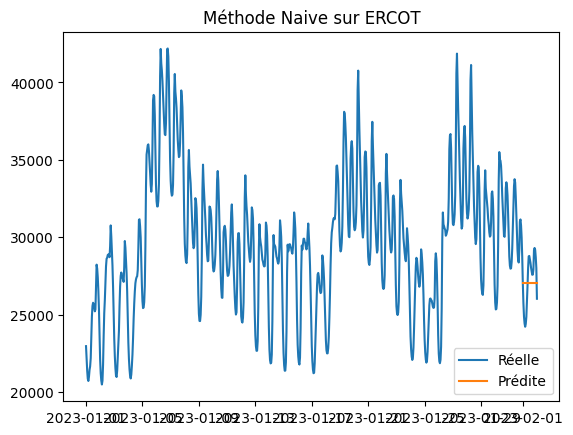

In [126]:
plt.plot(final_df.index, final_df.values[:, 0], label = 'Réelle')
plt.plot(final_df.index[-24:], [preds2[0]]*24, label = 'Prédite')
plt.title(f'Méthode Naive sur ERCOT')
plt.legend()
plt.show()